In [ ]:
## keyword: ResNet50_224

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-28 15:26:22.644897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745868382.664852    7194 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745868382.670818    7194 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745868382.686621    7194 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868382.686655    7194 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868382.686658    7194 computation_placer.cc:177] computation placer alr

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 224x224

#### ResNet50_224

In [3]:
# 1. Load dataset
data_224 = np.load("bloodmnist_224.npz")

# 2. Extract images and labels
train_images_224 = data_224["train_images"]
train_labels_224 = data_224["train_labels"].flatten()

val_images_224 = data_224["val_images"]
val_labels_224 = data_224["val_labels"].flatten()

test_images_224 = data_224["test_images"]
test_labels_224 = data_224["test_labels"].flatten()

# 3. One-hot encode labels
train_labels_cat_224 = to_categorical(train_labels_224, num_classes=8)
val_labels_cat_224 = to_categorical(val_labels_224, num_classes=8)
test_labels_cat_224 = to_categorical(test_labels_224, num_classes=8)

In [4]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 

train_generator_224 = train_datagen.flow(
    train_images_224, 
    train_labels_cat_224,   
    batch_size=batch_size
)
val_generator_224 = test_datagen.flow(
    val_images_224,
    val_labels_cat_224,
    batch_size=batch_size
)
test_generator_224 = test_datagen.flow(
    test_images_224,
    test_labels_cat_224,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
# 5. Set up ResNet50 
base_50_224 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

x = base_50_224.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_224 = Model(inputs=base_50_224.input, outputs=outputs)

2025-04-28 15:27:37.119852: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# 6. Compile model
model_50_224.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_224 = model_50_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3083s 8s/step - accuracy: 0.8786 - auc: 0.9775 - loss: 0.3712 - val_accuracy: 0.0713 - val_auc: 0.5000 - val_loss: 29.5317
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3052s 8s/step - accuracy: 0.9752 - auc: 0.9985 - loss: 0.0733 - val_accuracy: 0.2605 - val_auc: 0.7022 - val_loss: 3.7710
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3071s 8s/step - accuracy: 0.9828 - auc: 0.9992 - loss: 0.0482 - val_accuracy: 0.8867 - val_auc: 0.9940 - val_loss: 0.3261
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3082s 8s/step - accuracy: 0.9879 - auc: 0.9996 - loss: 0.0365 - val_accuracy: 0.9866 - val_auc: 0.9999 - val_loss: 0.0337
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3081s 8s/step - accuracy: 0.9873 - auc: 0.9997 - loss: 0.0348 - val_accuracy: 0.9790 - val_auc: 0.9989 - val_loss: 0.0594
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3072s 8s/step - accuracy: 0.9905 - auc: 0.9998 - loss: 0.0275 - val_accuracy: 0.9807 - val_auc: 0.9996 - val_loss: 0.0593
Epoch 7/10
374/374 ━━━━━━━━

In [7]:
model_50_224.save('model_output/ResNet50_224.h5')
model_50_224.save('model_output/ResNet50_224.keras')

# to load:
# from keras.models import load_model
# model_50_224 = load_model('model_output/ResNet50_224.h5')
# from tensorflow.keras.models import load_model
# model_50_224 = load_model('model_output/ResNet50_224.h5')

In [8]:
# 8. Evaluate model
test_loss_50_224, test_acc_50_224, test_auc_50_224 = model_50_224.evaluate(test_generator_224)
print(f"ResNet50 test accuracy for 224 pixels: {test_acc_50_224:.4f}")
print(f"ResNet50 test AUC for 224 pixels:      {test_auc_50_224:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9699 - auc: 0.9982 - loss: 0.1025
ResNet50 test accuracy for 224 pixels: 0.9734
ResNet50 test AUC for 224 pixels:      0.9984


In [10]:
# 9. Precision, recall, f1-score
y_prob_50_224 = model_50_224.predict(test_generator_224)
y_pred_50_224 = np.argmax(y_prob_50_224, axis=1)
y_true_224 = test_labels_224

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_50_224, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step
                      precision    recall  f1-score   support

          neutrophil       0.99      0.99      0.99       244
          eosinophil       1.00      1.00      1.00       624
            basophil       1.00      0.98      0.99       311
          lymphocyte       0.88      0.99      0.94       579
            monocyte       0.98      0.99      0.98       243
immature granulocyte       0.98      0.96      0.97       284
        erythroblast       1.00      0.90      0.95       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.97      3421
           macro avg       0.98      0.98      0.98      3421
        weighted avg       0.98      0.97      0.97      3421



In [11]:
# 10. Performance per class
cm_50_224 = confusion_matrix(y_true_224, y_pred_50_224)
per_class_acc_50_224 = cm_50_224.diagonal() / cm_50_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 0.9984
basophil             accuracy: 0.9839
lymphocyte           accuracy: 0.9948
monocyte             accuracy: 0.9877
immature granulocyte accuracy: 0.9613
erythroblast         accuracy: 0.9024
platelet             accuracy: 0.9979


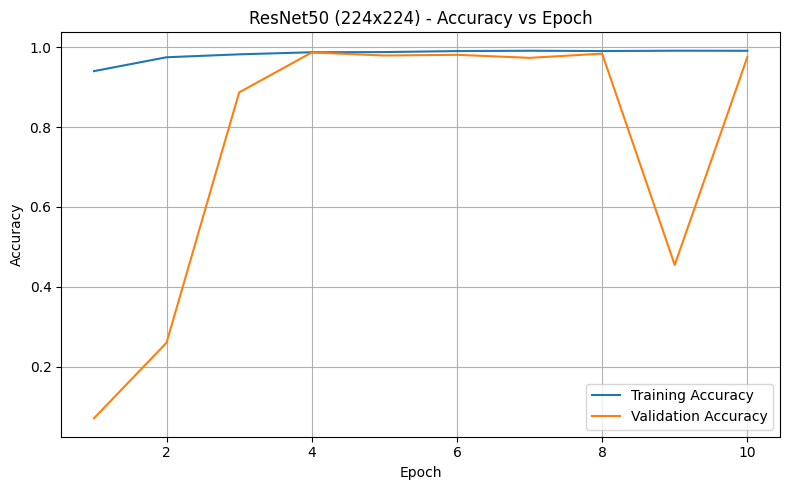

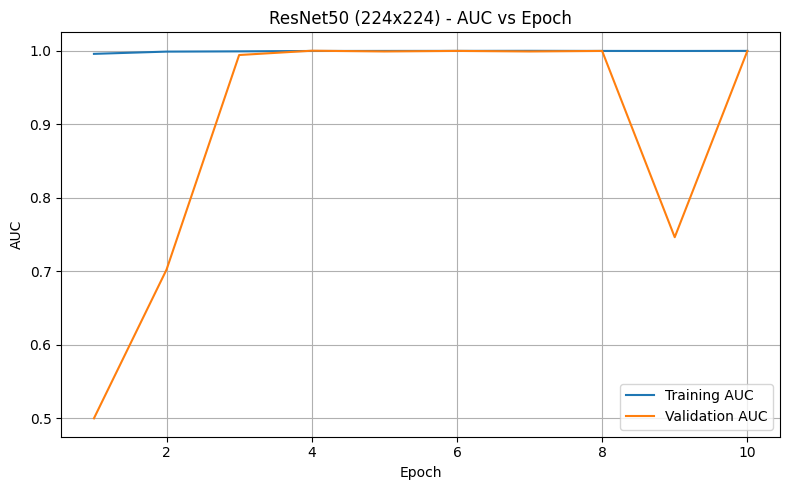

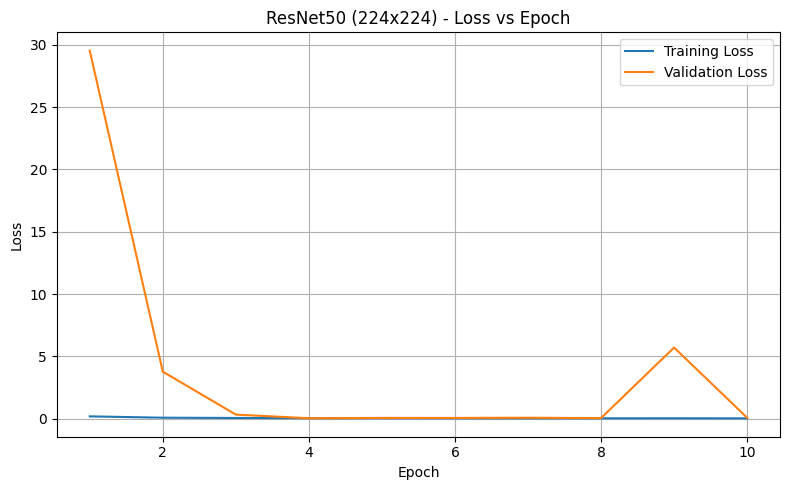

In [9]:
# 11. Plot
epochs = range(1, len(history_50_224.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_224.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (224x224) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_224.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_224.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (224x224) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_224.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_224.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (224x224) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_224.png")
plt.show()

#### ResNet101_224

In [5]:
# 5. Set up ResNet101
base_101_224 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

x = base_101_224.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_101_224 = Model(inputs=base_101_224.input, outputs=outputs)

2025-04-28 21:15:01.075707: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# 6. Compile model
model_101_224.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

# 7. Train model
history_101_224 = model_101_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3364s 9s/step - accuracy: 0.8750 - auc: 0.9800 - loss: 0.3495 - val_accuracy: 0.0905 - val_auc: 0.5002 - val_loss: 26.2013
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3283s 9s/step - accuracy: 0.9763 - auc: 0.9988 - loss: 0.0694 - val_accuracy: 0.3195 - val_auc: 0.6870 - val_loss: 5.1959
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3311s 9s/step - accuracy: 0.9822 - auc: 0.9993 - loss: 0.0519 - val_accuracy: 0.9708 - val_auc: 0.9996 - val_loss: 0.0826
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3163s 8s/step - accuracy: 0.9830 - auc: 0.9991 - loss: 0.0458 - val_accuracy: 0.9860 - val_auc: 0.9992 - val_loss: 0.0430
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3134s 8s/step - accuracy: 0.9881 - auc: 0.9995 - loss: 0.0347 - val_accuracy: 0.9550 - val_auc: 0.9964 - val_loss: 0.1518
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3130s 8s/step - accuracy: 0.9908 - auc: 0.9992 - loss: 0.0292 - val_accuracy: 0.9585 - val_auc: 0.9985 - val_loss: 0.1244
Epoch 7/10
374/374 ━━━━━━━━

In [7]:
model_101_224.save('model_output/ResNet101_224.h5')
model_101_224.save('model_output/ResNet101_224.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.keras')
# from tensorflow.keras.models import load_model
# model_101_64 = load_model('model_101_64.h5', compile=False)

In [8]:
# 8. Evaluate model
test_loss_101_224, test_acc_101_224, test_auc_101_224 = model_101_224.evaluate(test_generator_224)
print(f"ResNet101 test accuracy for 224 pixels: {test_acc_101_224:.4f}")
print(f"ResNet101 test AUC for 224 pixels:      {test_auc_101_224:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9841 - auc: 0.9984 - loss: 0.0593
ResNet101 test accuracy for 224 pixels: 0.9848
ResNet101 test AUC for 224 pixels:      0.9983


In [10]:
# 9. Classification report
y_prob_101_224 = model_101_224.predict(test_generator_224)
y_pred_101_224 = np.argmax(y_prob_101_224, axis=1)
y_true_224 = test_labels_224

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_101_224, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step
                      precision    recall  f1-score   support

          neutrophil       1.00      0.99      1.00       244
          eosinophil       1.00      1.00      1.00       624
            basophil       1.00      0.99      1.00       311
          lymphocyte       0.97      0.96      0.96       579
            monocyte       1.00      0.98      0.99       243
immature granulocyte       0.99      0.95      0.97       284
        erythroblast       0.96      0.99      0.98       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.98      3421
           macro avg       0.99      0.98      0.99      3421
        weighted avg       0.98      0.98      0.98      3421



In [11]:
# 10. Per-class accuracy
cm_101_224 = confusion_matrix(y_true_224, y_pred_101_224)
per_class_acc_101_224 = cm_101_224.diagonal() / cm_101_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 1.0000
basophil             accuracy: 0.9936
lymphocyte           accuracy: 0.9551
monocyte             accuracy: 0.9835
immature granulocyte accuracy: 0.9542
erythroblast         accuracy: 0.9925
platelet             accuracy: 1.0000


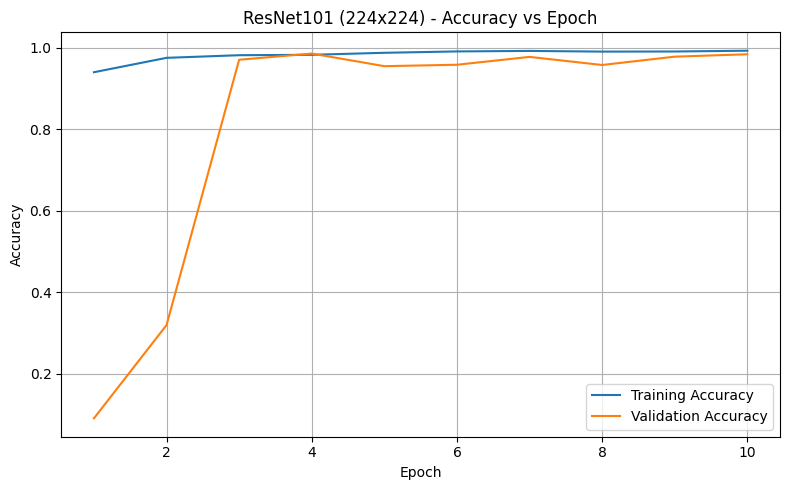

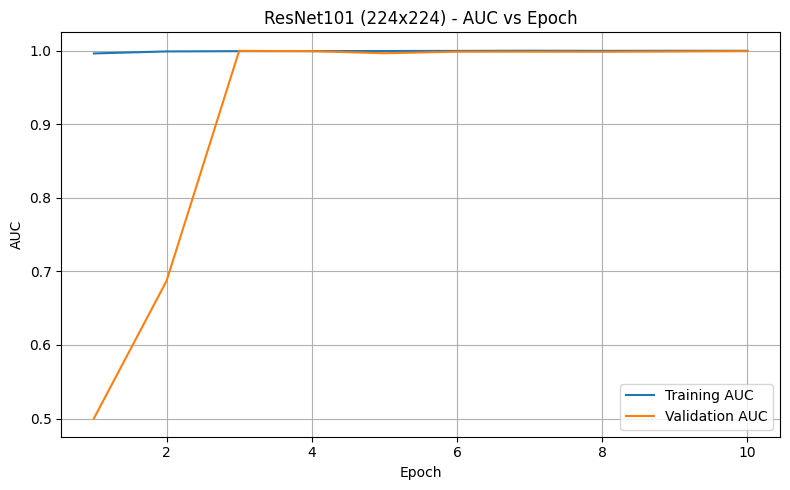

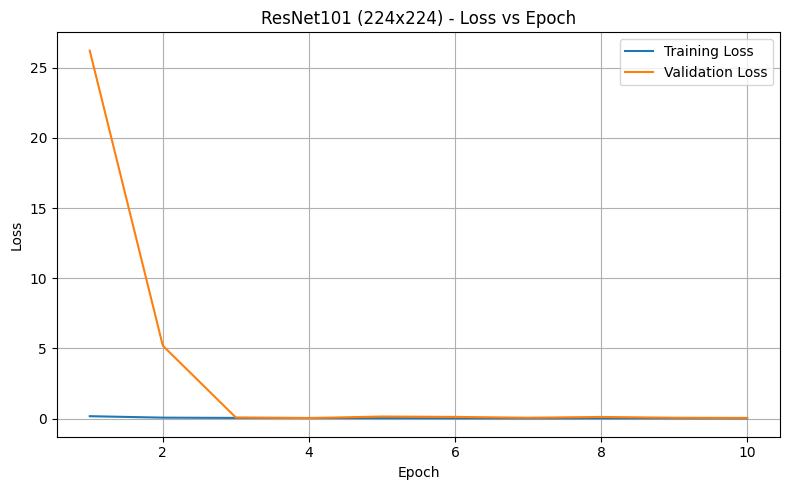

In [9]:
# 11. Plots
epochs = range(1, len(history_101_224.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_224.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (224x224) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_224.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_224.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (224x224) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_224.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_224.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (224x224) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_224.png")
plt.show()